In [39]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Lecture 24 #

## Reviewing Setup from Last Lecture

Recall, in our example from last class we actually had access to the population data.  
This is not normally the case.  The methods we are about to study **only make sense when you don't have access to the population.** 

In [41]:
sf = pd.read_csv('san_francisco_2019.csv')
min_salary = 15 * 20 * 52
sf = sf[sf["Salary"]>=min_salary]+
sf


,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
0,Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332.0,0.0,40059.0,131391.0
1,Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241.0,0.0,49279.0,172520.0
2,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715.0,0.0,46752.0,162468.0
3,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Principal,159394.0,0.0,57312.0,216706.0
4,Public Protection,Adult Probation,Information Systems,IS Programmer Analyst,70035.0,0.0,28671.0,98706.0
...,...,...,...,...,...,...,...,...
44520,General Administration & Finance,Treasurer/Tax Collector,Revenue,"Investigator, Tax Collector",44961.0,42.0,19546.0,64549.0
44521,General Administration & Finance,Treasurer/Tax Collector,Revenue,"Investigator, Tax Collector",85706.0,107.0,38924.0,124737.0
44522,General Administration & Finance,Treasurer/Tax Collector,Revenue,"Investigator, Tax Collector",101403.0,0.0,43185.0,144587.0
44523,General Administration & Finance,Treasurer/Tax Collector,Revenue,"Pr Investigator, Tax Collector",113738.0,397.0,47104.0,161240.0


array([[<AxesSubplot:title={'center':'Total Compensation'}>]],
      dtype=object)

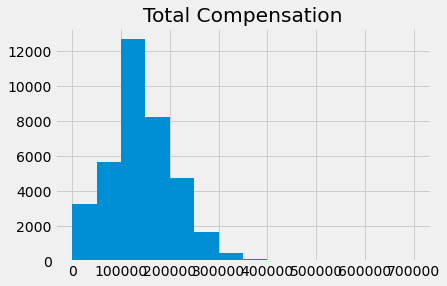

In [46]:
sf_bins = np.arange(0, 726000, 50000)
sf.hist('Total Compensation', bins=sf_bins)

### Defining the Statistic

Here we are interested in the median (50% percentile) of the total compensation. 

In [4]:
# Parameter: Median total compensation in the population
def median_comp(t):
    return t['Total Compensation'].median()

### The Population Parameter

We have access to the population so we can compute the **parameter** but in practice we typically won't have access to the population and instead we will have to *estimate* the parameter from a **sample**.

In [5]:
pop_median = median_comp(sf)
print("Parameter Value:", pop_median)

Parameter Value: 136164.0


### The Sample

In practice, the data we would get from most studies would be a **sample** of the entire population.  This is because collecting a full census is challenging and expensive.

Here we load the (fictional) sample that was taken by Prof. Oscamou

<details><summary>Unimportant and Not True Details</summary>

She collected this sample by selecting 400 names at random from the HR database and then directly asking them how much they make. It took all weekend and he had to give a chocolate to everyone who participated. 
    
    
<details><summary>The Real Truth</summary>
        
Actually, everything above is a complete fabrication.  Prof. Oscamou simply wrote: 
        
```python
sf.sample(400, replace=False).to_csv("sf_sample.csv")
```
        
</details>
    
</details>

In [6]:
sample_sf = pd.read_csv("sf_sample.csv")
sample_sf.head(5)

,Unnamed: 0,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
0,30718,Community Health,Public Health,Human Services,Hospital Eligibility Worker,15746.0,230.0,1240.0,17216.0
1,26940,Community Health,Public Health,"Payroll, Billing & Accounting",Accountant III,111816.0,0.0,46250.0,158066.0
2,26746,Community Health,Public Health,Information Systems,IS Business Analyst-Principal,106571.0,0.0,17000.0,123570.0
3,22031,"Public Works, Transportation & Commerce",Public Utilities Commission,Supervisory-Labor & Trade,Sewer Repair Supervisor,145342.0,10646.0,49299.0,205287.0
4,9420,"Public Works, Transportation & Commerce",Airport Commission,Management,Manager IV,152315.0,0.0,58910.0,211225.0


In [7]:
#Make sure our sample has the correct number of rows:

sample_sf.shape[0]

400

### Bootstrap Sampling

We introduced the following function that computes bootstrap samples of the statistic.
Note we recommend you use **10,000** repetitions when computing bootstrapped distributions.

In [42]:
def bootstrapper(sample, statistic, num_repetitions=10000):
    """
    Returns the statistic computed on a num_repetitions  
    bootstrap samples from sample.
    """
    bstrap_stats = np.array([])
    for i in np.arange(num_repetitions):
        # Step 1: Sample the Sample
        bootstrap_sample = sample.sample(frac=1, replace=True)
        # Step 2: compute statistics on the sample of the sample
        bootstrap_stat = statistic(bootstrap_sample)
        # Accumulate the statistics
        bstrap_stats = np.append(bstrap_stats, bootstrap_stat)

    return bstrap_stats    

In [9]:
bootstrap_medians = bootstrapper(sample_sf, median_comp, 10000)

### Examining the Bootstrapped Distribution of the Statistic

When using the boostrap it is important to always examine the distribution of the statistic.  In general when using bootstrapping we are looking for a distribution that is **roughly symmetric and bell-shaped**.

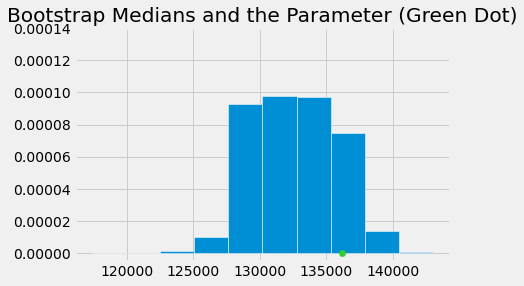

In [10]:
plt.hist(bootstrap_medians, density=True, ec='white');

parameter_green = '#32CD32'
plt.ylim(-0.000005, 0.00014)
plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plt.title('Bootstrap Medians and the Parameter (Green Dot)');

### Computing the Confidence Interval

We compute the confidence interval for our desired **confidence level** using the following code:

In [11]:
def compute_ci(bs_samples, confidence_level):
    """
    Returns the confidence interval for the provided bootstrap samples
    and desired confidence level.
    """
    tail_size = (100 - confidence_level)/2
    lower = np.percentile(bs_samples, tail_size,)
    upper = np.percentile(bs_samples, 100 - tail_size, )
    return [lower, upper]

In [12]:
ci = compute_ci(bootstrap_medians, 95)
ci

[127354.0, 138301.0]

Visualizing the CI

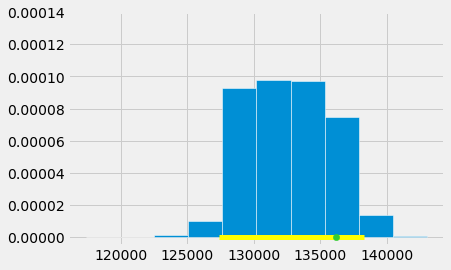

In [14]:
plt.hist(bootstrap_medians, density=True, ec='white');
# cool python trick to deconstruct the array!
[left, right] = ci
# Plotting parameters; you can ignore this code
plt.ylim(-0.000005, 0.00014)
plt.plot([left, right], [0, 0], color='yellow', lw=5, zorder=1)
plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


---

## Simulating the Simulation!

Let's look at what happens if we use the above code repeatedly with separate original samples from the population? How accurate are our 95% Bootstrap Estimates of the Parameter? 

In [47]:
intervals = pd.DataFrame(columns = ['lower', 'upper', 'median', 'good', 'sample size' ])

sample_sizes = [2,8,16,50, 100]
for sample_size in sample_sizes:
    for trial in np.arange(20): # Run 20 trials of each configuration
        # Pay for one new random sample from the population
        og_sample = sf.sample(sample_size, replace=False)
        
        # Compute the statistic on the sample
        sample_median = median_comp(og_sample)
        
        # Generate the medians of 10000 bootstrap samples
        bootstrap_medians = bootstrapper(og_sample, median_comp, 1000)
        
        # Construct the confidence interval
        [ci_lower, ci_upper] = compute_ci(bootstrap_medians, 95)
        
        # Determine if the confidence interval is good
        is_good = ci_lower <= pop_median <= ci_upper
        
        # Add a row with this data to the DataFrame
        
        intervals.loc[len(intervals.index)] = [ci_lower, ci_upper, sample_median, is_good, str(sample_size)]
    

        

# Add an experiment number
intervals["Experiment"]= np.arange(intervals.shape[0])

In [48]:
intervals

,lower,upper,median,good,sample size,Experiment
0,163671.0,175097.0,169384.0,False,2,0
1,111101.0,131476.0,121288.5,False,2,1
2,18167.0,197150.0,107658.5,True,2,2
3,105193.0,108886.0,107039.5,False,2,3
4,180080.0,187795.0,183937.5,False,2,4
...,...,...,...,...,...,...
95,122116.0,148513.0,129850.5,True,100,95
96,126108.0,166155.0,142092.0,True,100,96
97,124539.0,159966.0,134663.5,True,100,97
98,113932.8,152861.0,131434.5,True,100,98


Here I render a plot of all the confidence intervals with the true value depicted as a solid vertical line.  

In [49]:
import plotly.express as px

# Plotly will draw error bars which are the distance in each direction
# from the median
intervals["error_left"] = intervals["median"]-intervals["lower"]
intervals["error_right"] = intervals["upper"]-intervals["median"]


# Making the plot
fig = px.scatter(
    x=intervals["median"], # X location of my interval center dot
    y=intervals["Experiment"], # Y location of my interval center dot 
    color=intervals["sample size"], # The color to use.
    symbol=intervals["good"], # The column to use for the symbol
    symbol_map={True: "circle", False: "circle-open"},
    error_x=intervals["error_right"], # upper error bar size
    error_x_minus=intervals["error_left"], # lower error bar size
    height=800)
fig.add_vline(pop_median)

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


## Confidence Interval for Unknown Population Mean

Now let's look at a more appropriate use of the bootstrap (when we don't have the population).  The baby table from prior lecture had a random sample of moms.

In [18]:
# Random sample of mother-newborn pairs
births = pd.read_csv('baby.csv')
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


What is the average age of moms who are having children in the entire population?

**Parameter:** Average age of moms when they give birth to first child.

**Statistic:** Average age of moms in our sample.

In [19]:
# Average age of mothers in the sample
births['Maternal Age'].mean()

27.228279386712096

Remember there was a distribution of ages.

Text(0.5, 1.0, 'Distribution of Age in our SAMPLE')

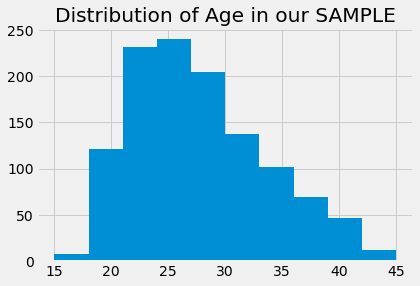

In [20]:
births.hist('Maternal Age')
plt.title("Distribution of Age in our SAMPLE")


We could have also returned the median or even a range of ages as our statistic:

In [21]:
births['Maternal Age'].median()

26.0

Or an interval of 95% of the ages:

In [22]:
[np.percentile(births['Maternal Age'],2.5),
 np.percentile(births['Maternal Age'],97.5)]

[19.0, 40.0]

Is this a confidence interval?
<br><br><br><br>

### Compute the Sample Statistic
Since we are interested in estimating the average age of mothers in the population we will use the average age statistic:

In [23]:
def avg_maternal_age(sample):
    return sample["Maternal Age"].mean()

In [24]:
sample_statistic = avg_maternal_age(births)
sample_statistic

27.228279386712096

### Use the Bootstrap to Estimate the CI 

The interval of estimates is the "middle 95%" of the bootstrap estimates.

This is called a *95% confidence interval* for the **mean age in the population**.


In [25]:
bootstrap_means = bootstrapper(births, avg_maternal_age, 10000)
avg_maternal_age_ci = compute_ci(bootstrap_means, confidence_level=95)
avg_maternal_age_ci

[26.905451448040886, 27.56984667802385]

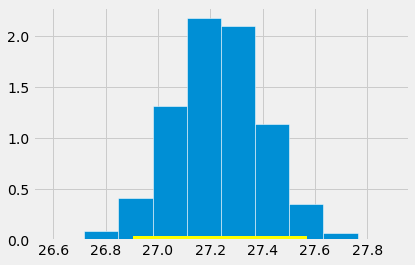

In [26]:
plt.hist(bootstrap_means, density=True, ec='white');


[left, right] = avg_maternal_age_ci
plt.plot([left, right], [0, 0], color='yellow', lw=8);

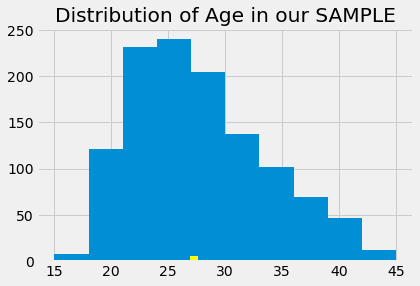

In [27]:
# Now we can visualize this interval back on our sample
# Notice tiny yellow bar at the bottom:
births.hist('Maternal Age')
plt.title("Distribution of Age in our SAMPLE")

plt.plot([left, right], [0, 0], color='yellow', lw=10);

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


## Using the Confidence Interval for Testing Hypotheses

**Null:** The average age of mothers in the population is 25 years; the random sample average is different due to chance.

**Alternative:** The average age of the mothers in the population is not 25 years.

Suppose you use the 5% cutoff for the p-value.

Based on the confidence interval, which hypothesis would you pick?

In [28]:
bootstrap_means = bootstrapper(births, avg_maternal_age, 10000)
avg_maternal_age_ci = compute_ci(bootstrap_means, confidence_level=95)
avg_maternal_age_ci

[26.89778534923339, 27.56558773424191]

Suppose you use the 0.1% cutoff for the p-value.


In [29]:
bootstrap_means = bootstrapper(births, avg_maternal_age, 10000)
avg_maternal_age_ci = compute_ci(bootstrap_means, confidence_level=99.9)
avg_maternal_age_ci

[26.706981260647357, 27.75641098807496]

check it: https://www.cdc.gov/nchs/nsfg/key_statistics/b.htm

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


## Using CLT to Calculate the CI for Age:



In [32]:
sample_mean=births['Maternal Age'].mean()
sample_mean

In [34]:
standard_error = births['Maternal Age'].std()/np.sqrt(len(births["Maternal Age"]))
standard_error

0.16979606801968558

In [36]:
#95% CI
L = sample_mean-2*standard_error
U = sample_mean+2*standard_error

[L,U]

[26.888687250672724, 27.567871522751467]

In [37]:
#Compare to bootstrapped example:
avg_maternal_age_ci

[26.706981260647357, 27.75641098807496]